# Code

In [1]:
%load_ext autoreload

In [2]:
from plot_setup import * 
import MCgenerator, dSph_model, coord
from numpy import power,sqrt
from scipy.stats import norm

In [3]:
%autoreload 2

In [4]:
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
RA0 = draco_prop.RAdeg
DE0 = draco_prop.DEdeg
DIST = draco_prop.DIST
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [5]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
# v001: for mycut
# v002: for spectroscopy cut

## definition of likelihood

In [64]:
class KI17_loglikelihood_mod_cont:
    def __init__(self,vs,beta=1):
        self.vs = vs
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args))
    
    def is_parameters_in_domain(self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 < vfg1 < vfg2
        is_ffg_normalized_ = 0<=sfg0<=1 and 0<=sfg1<=1 and (sfg0+sfg1)<=1
        is_not_fast = np.all(np.abs(np.array([vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2]))<3e8)
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_not_fast)
    
    def loglikelis(
        self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            sfg2 = 1-sfg0-sfg1
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(ffg)

            return self.beta * ret
        
    def fit_plot(self,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1,bins=64,**kwargs):
        fig,ax = plt.subplots(1,1)
        vs=self.vs
        sfg2 = 1-sfg0-sfg1 
        ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
        ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
        ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
        ffg = ffg0+ffg1+ffg2
        df = pd.DataFrame()
        df[r"$v$"] = vs
        df["$f_{FG,0}$"] = ffg0
        df["$f_{FG,1}$"] = ffg1
        df["$f_{FG,2}$"] = ffg2
        df["$f_{FG,tot}$"] = ffg
        
        df = df.sort_values(r"$v$")
        
        ax.hist(vs,density=True,bins=bins)
        df.plot(x=r"$v$",ax=ax,**kwargs)


In [144]:
#update likelihood
def is_positive(*args):
    return np.array(args)>0

class KI17_loglikelihood_mod:
    def __init__(self,vs,dRAs,dDEs,beta=1):
        self.vs = vs
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        mem = dSph_model.plummer_model(re_pc=200)
        dm = dSph_model.NFW_model(a=2.78,b=7.78,g=0.675,rhos_Msunpc3=np.power(10,-2.05),rs_pc=np.power(10,3.96),R_trunc_pc=2000)
        self.dsph = dSph_model.dSph_model(anib=-0.5,submodels_dict={"stellar_model":mem,"DM_model":dm},show_init=True)
        
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R,show_init=True)


    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")

    def logprior(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,dvfg0,dvfg1, sfg0):
        
        G_re = norm.pdf(re,loc=191,scale=5.7)
        #G_odds = norm.pdf(odds,loc=8.794,scale=0.5107)
        G_dra0 = norm.pdf(dra0,loc=4.212e-3,scale=7.052e-3)
        G_dde0 = norm.pdf(dde0,loc=-1.991e-3,scale=3.302e-3)
        
        return np.sum(np.log([G_re,G_dra0,G_dde0]))

    def __call__(self,**args):
        return np.sum(self.loglikelis(**args)) + self.logprior(**args)
    
    def is_parameters_in_domain(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,dvfg0,dvfg1, sfg0):
        is_positive_ = np.all(is_positive(re,odds,dvfg0,dvfg1))
        is_vfg_ordered_ = vfg0 < vfg1
        is_ffg_normalized_ = 0<sfg0<1
        is_in_domain_ = -1<mlog10_1manib<1 and -4<log10_rhos_Msunpc3<4 and 0<log10_rs_pc<5 and 0.5<a<3 and 3<b<10 and 0<g<1.2
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_in_domain_)
    
    def loglikelis(
        self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,dvfg0,dvfg1, sfg0
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(re,odds,dra0,dde0,
                log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
                mlog10_1manib,
                vmem,vfg0,vfg1,dvfg0,dvfg1, sfg0):
            return -np.inf
        else:
            vs=self.vs
            mem,dm,fg = self.dsph.submodels["stellar_model"],self.dsph.submodels["DM_model"],self.fg
            mem.update({"re_pc":re})
            dm.update({"rs_pc":power(10,log10_rs_pc),"rhos_Msunpc3":power(10,log10_rhos_Msunpc3),"a":a,"b":b,"g":g})
            self.dsph.update({"anib":1-power(10,-mlog10_1manib)})
            ref_R = mem.half_light_radius() # 1.67834699001666*re
            
            Rs = self.Rs(dra0,dde0)
        
            s = 1/(1+ 1/(odds * mem.density_2d_normalized_re(Rs)))
            sigmalos = self.dsph.sigmalos_dequad_interp1d_downsampled(Rs)
            sfg1 = 1-sfg0
            
            fmem = norm.pdf(vs,loc=vmem,scale=sigmalos)
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg = ffg0+ffg1
            
            #print("sigmalos:{}".format(sigmalos))
            #print("fmem:{}".format(fmem))
            #print("s*fmem+(1-s)*ffg:{}".format(s*fmem+(1-s)*ffg))
            ret = np.log(s*fmem+(1-s)*ffg)

            return self.beta * ret


Text(0,0.5,'$y$[deg]')

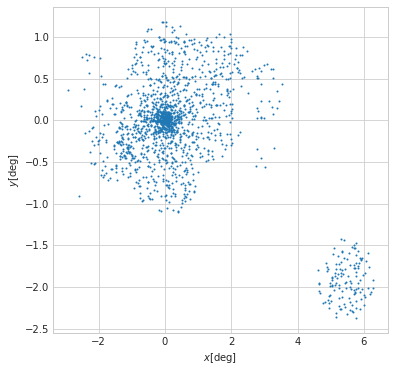

In [8]:
df0 = pd.read_csv("dra_sspp2_RADEdeg.csv")
#display(df0)
df_deg = pd.DataFrame(df0[["RAdeg","DEdeg"]])
df_rad = np.deg2rad(pd.DataFrame(df_deg))

df_deg["x"] = df_deg["RAdeg"] - RA0
df_deg["y"] = df_deg["DEdeg"] - DE0

#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.RAdeg
de = df_deg.DEdeg
vs = df0.Vlos

arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":RA0,"de_center":DE0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=DIST,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 4
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))
plt.xlabel(r"$x$[deg]")
plt.ylabel(r"$y$[deg]")

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78c25df9b0>]],
      dtype=object)

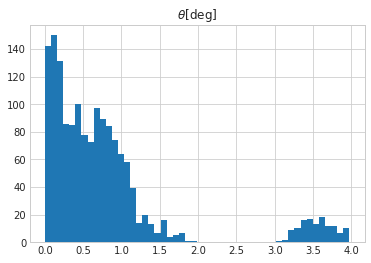

In [8]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78ba6866a0>]],
      dtype=object)

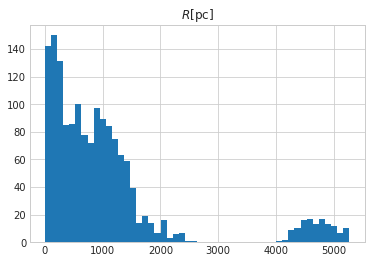

In [9]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

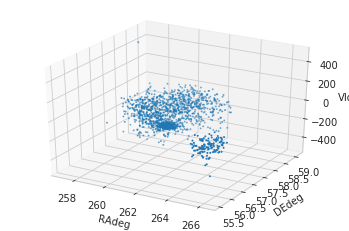

In [10]:
df0[["RAdeg","DEdeg","Vlos"]].plot_scatter3D("RAdeg","DEdeg","Vlos",s=1)

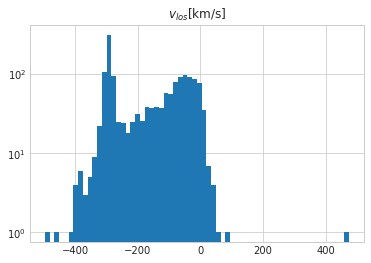

In [334]:
df_vlos = pd.DataFrame({r"$v_{los}$[km/s]":df0.Vlos.values})
df_vlos.hist(bins=64)
len(df0)
plt.yscale("log")

127

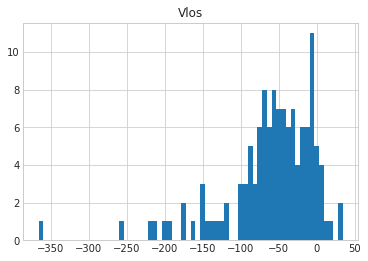

In [142]:
df_plot = df0[Rs>3000]
df_plot.hist("Vlos",bins=64)
len(df_plot)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7878324e48>]],
      dtype=object)

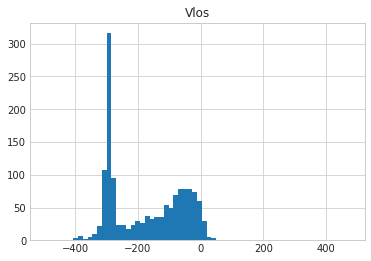

In [115]:
df0[angles<2.5].hist("Vlos",bins=64)

## likelihood compile

In [145]:
isin_sig = Rs<3000
loglikeli_cont =  KI17_loglikelihood_mod_cont(vs=vs[np.logical_not(isin_sig)])
loglikeli = KI17_loglikelihood_mod(vs=vs[isin_sig],dRAs=df_deg.x[isin_sig],dDEs=df_deg.y[isin_sig])
#sigmalos2 = loglikeli.dsph.sigmalos2_using_mykernel(loglikeli.Rs(0,0))
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

initialized:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64
initialized:
Rmax_pc    2531.745788
dtype: float64


# MCMC

## Cont

In [304]:
gen_cont = MCgenerator.MCgenerator(
    args_logpdf_init={
        "vfg0": -152.939605,
        "vfg1": -43.608103,
        "vfg2": -4.512821,
        "dvfg0": 80.441576,
        "dvfg1": 33.495326,
        "dvfg2": 0.490637,
        "sfg0":  0.183776,
        "sfg1":  0.773582},
#    args_logpdf_init={
#        'vfg0':-136, 'vfg1':-46, 'vfg2':-5, 'dvfg0':93, 'dvfg1':32,'dvfg2':0.6,
#        'sfg0':0.25,'sfg1':0.66
#    },
    dargs_logpdf={
        'vfg0':30, 'vfg1':8, 'vfg2':0.001, 'dvfg0':15, 'dvfg1':6,'dvfg2':0.001,
        'sfg0':0.05,'sfg1':0.05
    },
    logpdf_func=loglikeli_cont
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [246]:
loglikeli_cont(**{
        'vfg0':-4e8, 'vfg1':-200, 'vfg2':-0, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.01,'sfg1':0.2
    })

TypeError: loglikelis() got an unexpected keyword argument 'kwargs'

In [305]:
Nstep_init = 100000
gen_cont.generate(Nstep_init)

MCgeneration start.
options: {}
25.052% completed... acceptance rate: 7.12%
49.840% completed... acceptance rate: 7.26%
73.668% completed... acceptance rate: 7.35%
98.553% completed... acceptance rate: 7.44%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dvfg0  dvfg1  dvfg2  sfg0  sfg1  vfg0  vfg1   vfg2  iter_num
0   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000


In [308]:
#gen_cont.generate(100000)
gen_cont.generate_tuned([100000]*10)

MCgeneration start.
options: {}
25.006% completed... acceptance rate: 7.64%
49.825% completed... acceptance rate: 7.81%
74.754% completed... acceptance rate: 7.62%
99.310% completed... acceptance rate: 7.62%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dvfg0  dvfg1  dvfg2  sfg0  sfg1  vfg0  vfg1   vfg2  iter_num
0   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000
1   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000
0th iteration: update dargs_logpdf. 
before:
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
dtype: float64
after:
vfg0     31.123157
vfg1      4.500834
vfg2      0.017810
dvfg0    17.595276
dvfg1     3.819104
dvfg2     0.021978
sfg0      0.066832
sfg1      0.069415
dtype: float64
MCgeneration start.
options: {}
26.518% completed... acceptance rate: 8.70%
52.679% completed... acceptance rate: 8.95%
75.405% completed... acceptance rate: 8.73%
MCgeneration en

/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


MCgeneration end.
MCresults are stored.
MCinfo are logged.
        dvfg0      dvfg1      dvfg2      sfg0      sfg1        vfg0  \
0   15.000000   6.000000   0.001000  0.050000  0.050000   30.000000   
1   15.000000   6.000000   0.001000  0.050000  0.050000   30.000000   
2   17.595276   3.819104   0.021978  0.066832  0.069415   31.123157   
3   17.813542   3.847406   0.538664  0.067345  0.069992   31.667525   
4  355.601066  25.332066  12.274535  0.104043  0.243732  297.239671   

        vfg1       vfg2  iter_num  
0   8.000000   0.001000    100000  
1   8.000000   0.001000    100000  
2   4.500834   0.017810    100000  
3   4.589748   0.388377    100000  
4  50.761486  17.259047    100000  
3th iteration: update dargs_logpdf. 
before:
vfg0     297.239671
vfg1      50.761486
vfg2      17.259047
dvfg0    355.601066
dvfg1     25.332066
dvfg2     12.274535
sfg0       0.104043
sfg1       0.243732
dtype: float64
after:
vfg0     348.856598
vfg1      42.947205
vfg2      17.057708
dvfg0    23

32.860% completed... acceptance rate: 8.75%
65.948% completed... acceptance rate: 8.55%
99.019% completed... acceptance rate: 8.51%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
           dvfg0      dvfg1      dvfg2      sfg0      sfg1          vfg0  \
0   1.500000e+01   6.000000   0.001000  0.050000  0.050000  3.000000e+01   
1   1.500000e+01   6.000000   0.001000  0.050000  0.050000  3.000000e+01   
2   1.759528e+01   3.819104   0.021978  0.066832  0.069415  3.112316e+01   
3   1.781354e+01   3.847406   0.538664  0.067345  0.069992  3.166753e+01   
4   3.556011e+02  25.332066  12.274535  0.104043  0.243732  2.972397e+02   
5   2.320884e+02  21.364040  12.669393  0.041880  0.276156  3.488566e+02   
6   1.620165e+03  19.403820   5.806606  0.035895  0.117882  3.282994e+03   
7   1.547460e+04  15.407702   3.478079  0.007627  0.068198  6.297656e+04   
8   4.362148e+05  17.045686   3.535417  0.008099  0.067870  4.853299e+06   
9   7.806405e+06  16.009994   3.559832  0.007913 

,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2,sfg0,sfg1,logpdf
count,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,-143.596133,-44.250901,-4.466668,85.589639,34.254975,1.377433,0.199549,0.740616,-676.859011
std,30.844280,4.587111,1.254558,18.672164,3.829658,0.629094,0.077383,0.081665,2.523194
min,-344.061426,-67.293801,-8.323359,38.354487,14.924139,0.252983,0.018889,0.326128,-692.465434
25%,-163.271948,-47.228429,-5.085312,73.959060,31.710417,0.791092,0.150126,0.705001,-678.400625
50%,-142.280110,-44.141434,-4.646645,83.354838,34.052971,1.547191,0.188954,0.749629,-676.542932
75%,-122.083512,-41.214923,-4.233057,94.236887,36.539862,1.954555,0.233116,0.793885,-675.048179
max,-51.687870,-21.686320,1.661976,315.300359,53.532150,2.406135,0.629743,0.940728,-671.594139


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7865527978>,
      dtype=object)

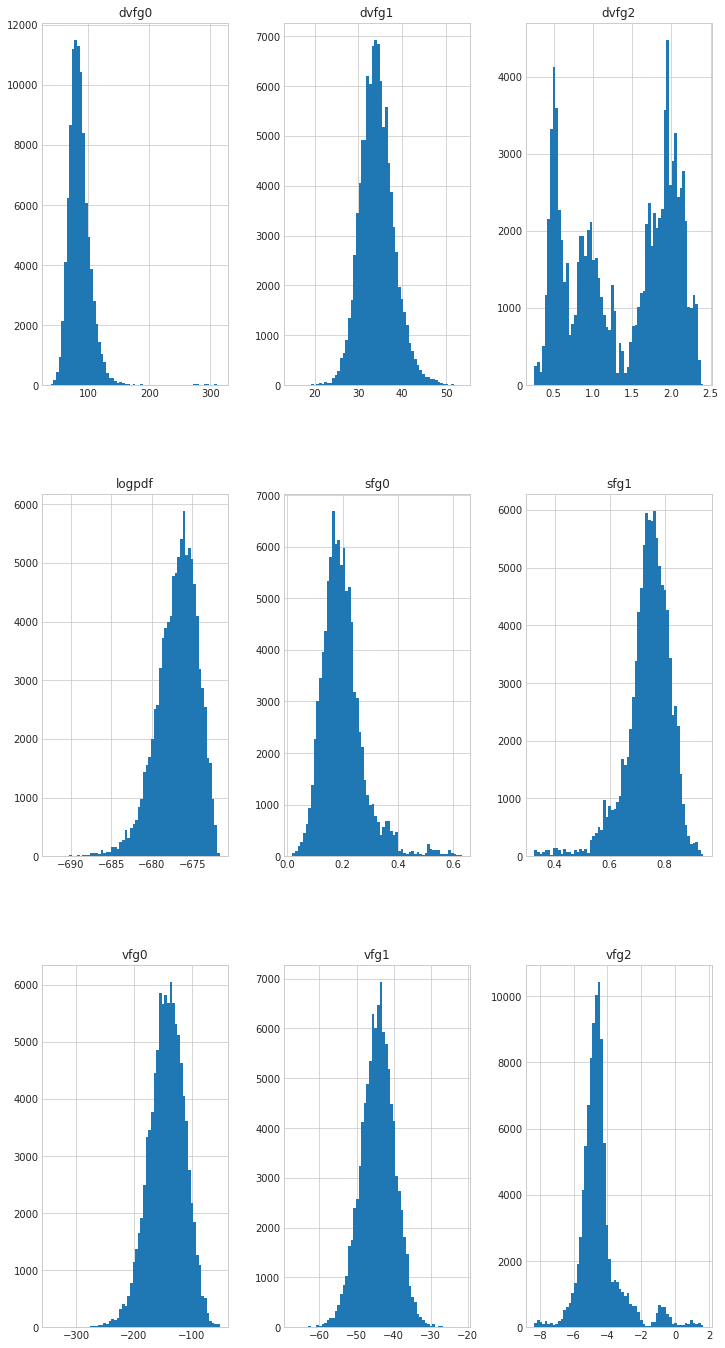

In [293]:
display(gen_cont.to_DataFrame().describe())
gen_cont.to_DataFrame().hist(bins=64,figsize=(12,24))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78528a9198>,
      dtype=object)

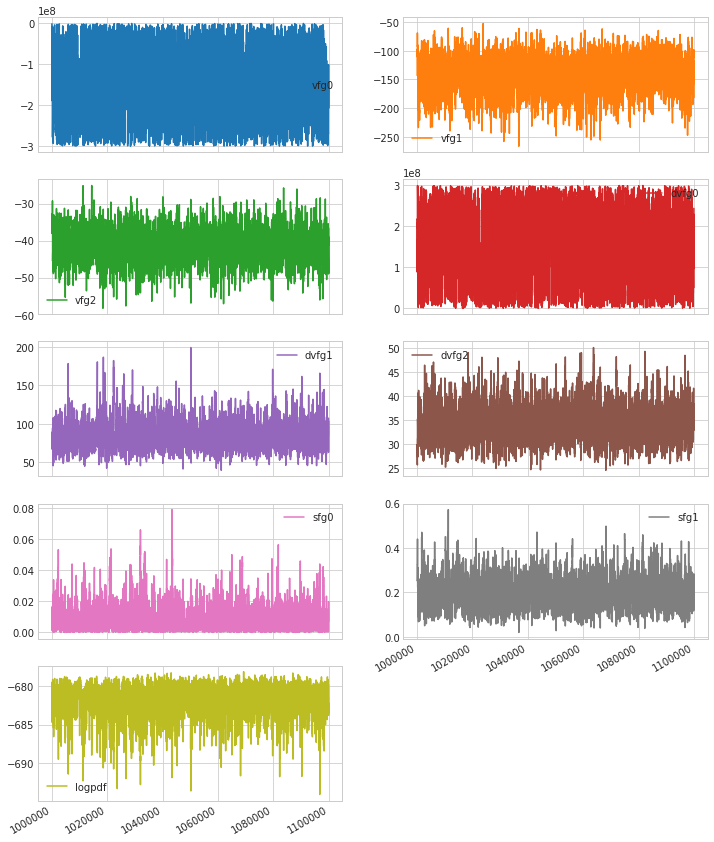

In [344]:
gen_cont.to_DataFrame()[1000000:].plot(subplots=True,figsize=(12,16),layout=(5,2))

In [369]:
argmax_full = gen_cont.to_DataFrame().sort_values(by="logpdf").iloc[-1]
argmax_last = gen_cont.to_DataFrame()[-100000:].sort_values(by="logpdf").iloc[-1]
display(argmax_full)
display(argmax_last)
argmax_2gaussian = argmax_last.copy()
argmax_2gaussian.sfg0 = 0
logpdf_2gaussian = loglikeli_cont(**argmax_2gaussian[:-1])
display(logpdf_2gaussian)
display(logpdf_2gaussian-argmax_2gaussian.logpdf)

vfg0     -136.303453
vfg1      -43.035090
vfg2       -4.614431
dvfg0      79.619452
dvfg1      34.021514
dvfg2       0.563076
sfg0        0.201259
sfg1        0.748665
logpdf   -671.563592
Name: 112384, dtype: float64

vfg0     -1.211323e+08
vfg1     -1.468893e+02
vfg2     -4.099918e+01
dvfg0     8.463548e+07
dvfg1     7.496235e+01
dvfg2     3.352920e+01
sfg0      1.121326e-03
sfg1      1.758627e-01
logpdf   -6.782046e+02
Name: 1069288, dtype: float64

-678.0629072486989

0.14169669182399502

Text(0.5,0,'$v_{los}$[km/s]')

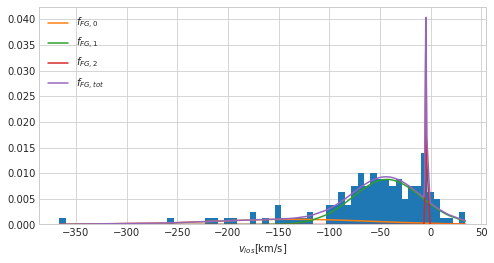

In [353]:
argmax_ = argmax[argmax.index[:-1]]
loglikeli_cont.fit_plot(**argmax_,figsize=(8,4))
plt.xlabel(r"$v_{los}$[km/s]")

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

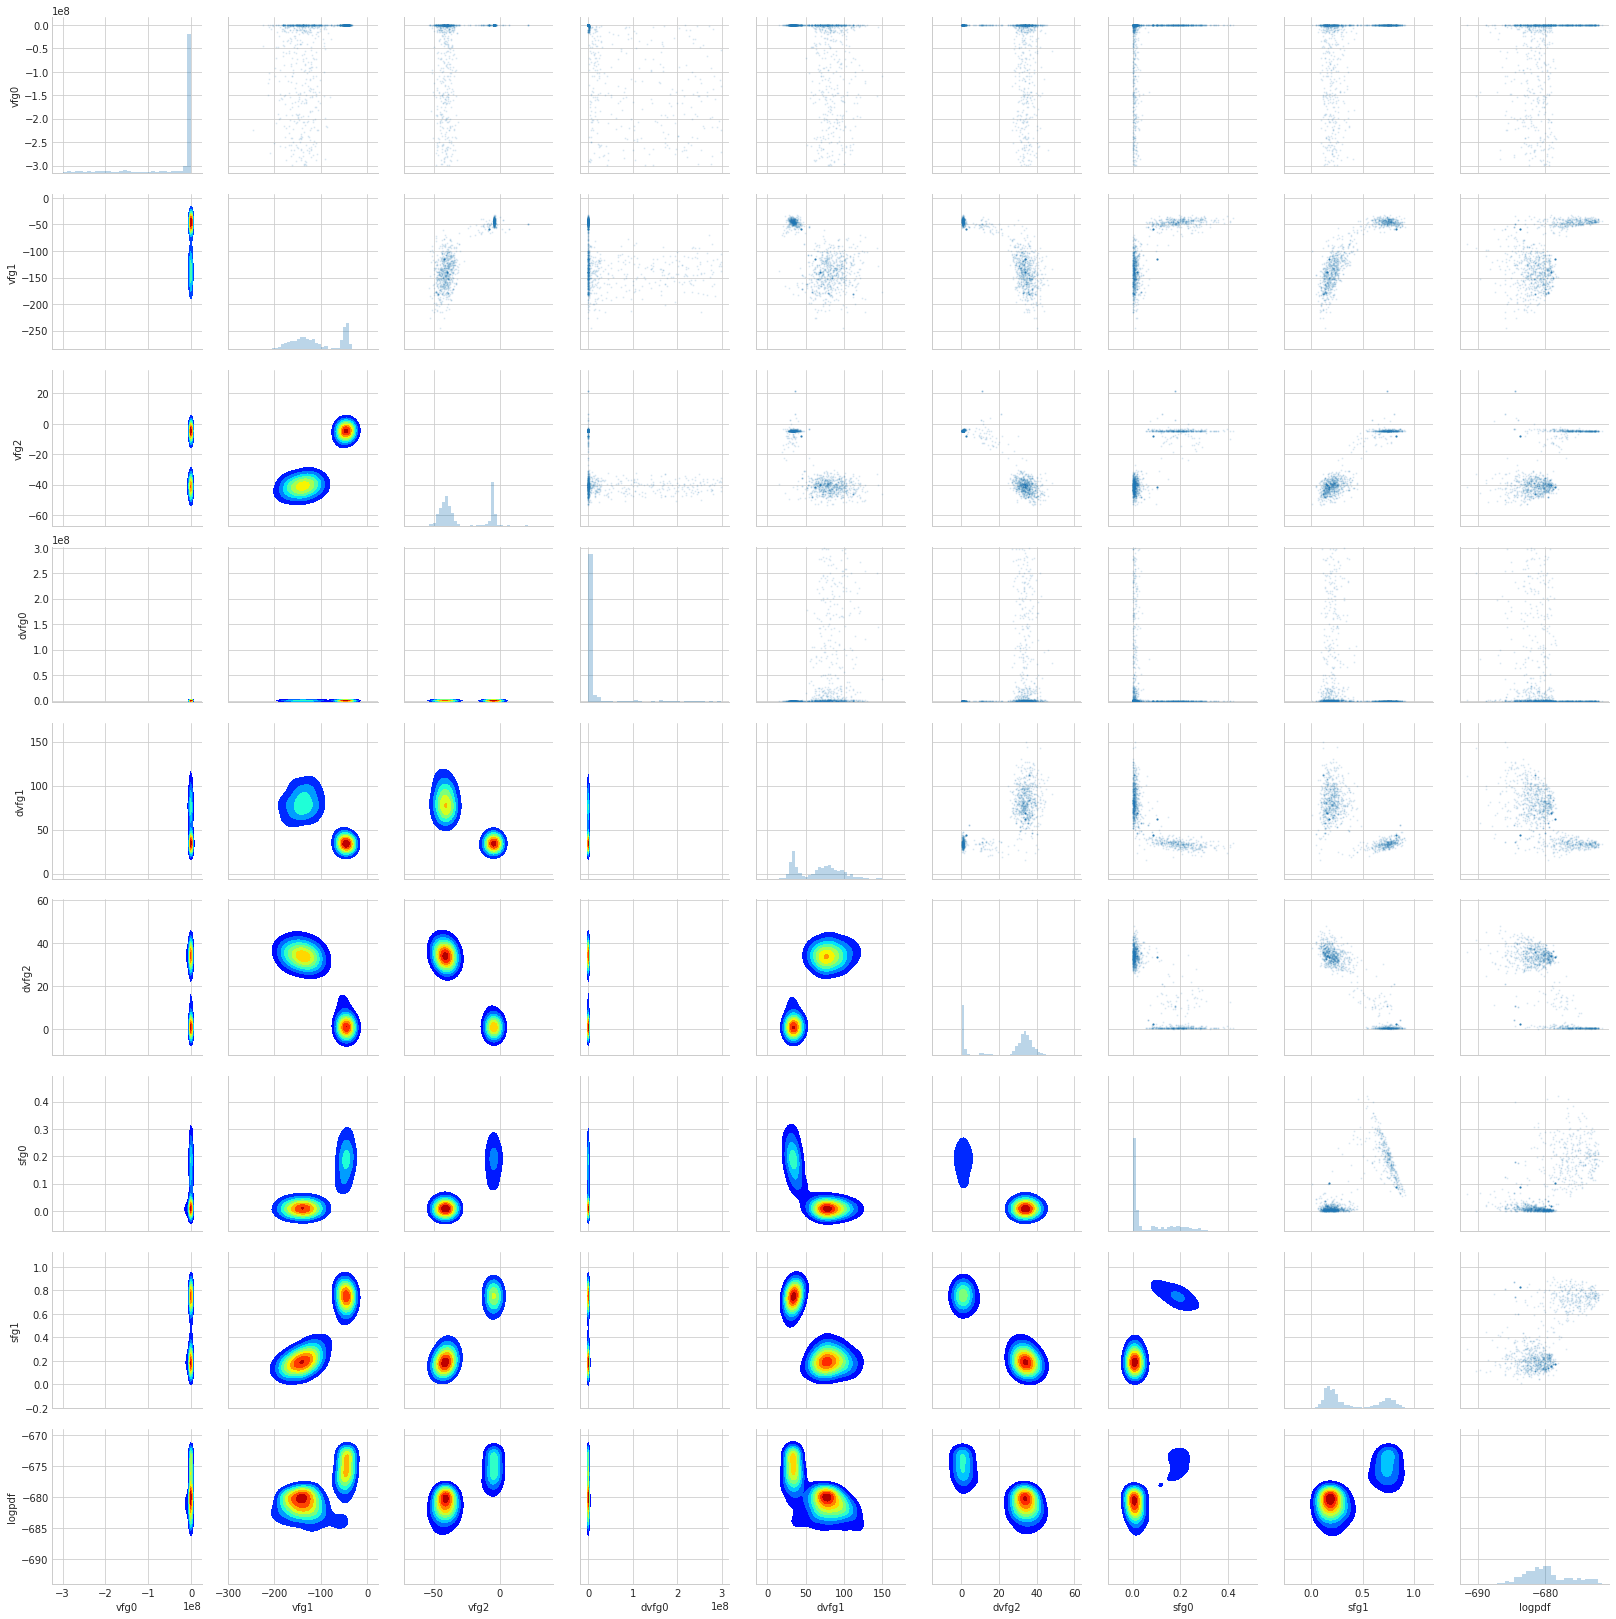

In [310]:
mypairplot(gen_cont.to_DataFrame()[::1000])

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


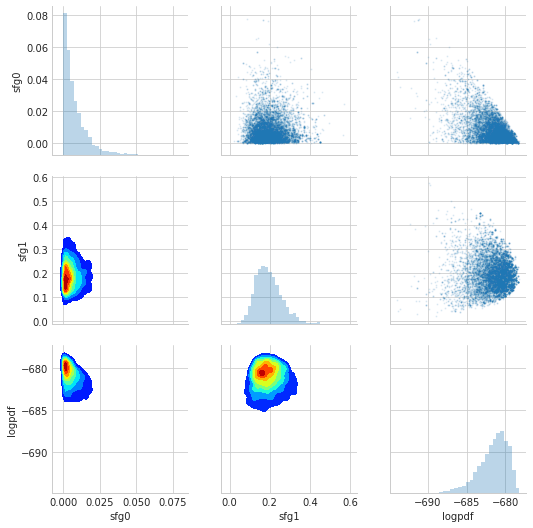

In [374]:
mypairplot(gen_cont.to_DataFrame()[-100000:][["sfg0","sfg1","logpdf"]][::10])

In [368]:
beta = 1/np.log(len(loglikeli_cont.vs))
display(1/beta)
bic_ = -gen_cont.to_DataFrame()["logpdf"].max() + (len(gen_cont.to_DataFrame().columns)-1)/2/beta
bic_

4.844187086458591

690.9403400742224

In [367]:
beta = 1/np.log(len(loglikeli_cont.vs))
bic_ = -logpdf_2gaussian + (3*2-1)/2/beta
bic_

690.1733749648454

In [314]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
#gen_cont.to_csv(FNAME_BASE.format("",SPECIFY_NAME,VERSION))
gen_cont.to_csv(FNAME_BASE.format("log",SPECIFY_NAME,VERSION),output_log=True)

## Sig

In [141]:
display(gen.to_DataFrame().iloc[4562])
loglikeli(**{
        "re":200, "odds":6.5,"dra0":0.0,"dde0":0.0,
        "log10_rs_pc":4, 'log10_rhos_Msunpc3':-2., 'a':3., 'b':7., 'g':0.5, 'mlog10_1manib':0., 
        'vmem':-200, 'vfg0':-250, 'vfg1':-200, 'dvfg0':50, 'dvfg1':50,
        'sfg0':0.3
    })

re                     195.704455
odds                     7.032856
dra0                    -0.071809
dde0                     0.001678
log10_rs_pc              3.940351
log10_rhos_Msunpc3      -1.704812
a                        2.392723
b                        7.385361
g                        0.474204
mlog10_1manib            0.319126
vmem                  -292.454006
vfg0                  -164.665258
vfg1                   -46.159334
dvfg0                   96.647425
dvfg1                   36.820849
sfg0                     0.537576
logpdf               -7644.706546
Name: 4562, dtype: float64

-inf

In [146]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={
        "re":191, "odds":7.5,"dra0":0.0,"dde0":0.0,
        "log10_rs_pc":4, 'log10_rhos_Msunpc3':-2, 'a':3, 'b':7, 'g':0.5, 'mlog10_1manib':0, 
        'vmem':-300, 'vfg0':-175, 'vfg1':-48, 'dvfg0':95, 'dvfg1':38,
        'sfg0':0.5,
    },
    dargs_logpdf={
        "re":5.0,"odds":0.5,"dra0":0.01,"dde0":0.01,
        "log10_rs_pc":0.1,'log10_rhos_Msunpc3':0.1, 'a':0.1, 'b':0.1, 'g':0.1, 'mlog10_1manib':0.1, 
        'vmem':1, 'vfg0':1, 'vfg1':1, 'dvfg0':1, 'dvfg1':1,
        'sfg0':0.01
    },
    logpdf_func=loglikeli
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
update dargs_logpdf:
before:
{}
after:
re                    5.00
odds                  0.50
dra0                  0.01
dde0                  0.01
log10_rs_pc           0.10
log10_rhos_Msunpc3    0.10
a                     0.10
b                     0.10
g                     0.10
mlog10_1manib         0.10
vmem                  1.00
vfg0                  1.00
vfg1                  1.00
dvfg0                 1.00
dvfg1                 1.00
sfg0                  0.01
dtype: float64
MCparameters are initialized.


In [ ]:
gen.logpdf_func.dsph.submodels["stellar_model"].cdf_R(gen.logpdf_func.Rs(0,0))

In [147]:
Nstep_init = 5000
gen.generate(Nstep_init)

MCgeneration start.
options: {}
10.480% completed... acceptance rate: 4.39%
20.420% completed... acceptance rate: 3.33%
30.260% completed... acceptance rate: 3.37%
39.700% completed... acceptance rate: 3.22%
49.240% completed... acceptance rate: 3.01%
58.780% completed... acceptance rate: 2.82%
68.140% completed... acceptance rate: 2.76%
77.520% completed... acceptance rate: 2.81%
86.520% completed... acceptance rate: 2.82%
95.420% completed... acceptance rate: 2.93%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
re                    5.00
odds                  0.50
dra0                  0.01
dde0                  0.01
log10_rs_pc           0.10
log10_rhos_Msunpc3    0.10
a                     0.10
b                     0.10
g                     0.10
mlog10_1manib         0.10
vmem                  1.00
vfg0                  1.00
vfg1                  1.00
dvfg0                 1.00
dvfg1                 1.00
sfg0                  0.01
dtype: float64


In [163]:
%%time
gen.generate_tuned([50000,50000,50000],proposal_dist="multivariate_normal")

MCgeneration start.
options: {}
1.164% completed... acceptance rate: 3.95%
2.778% completed... acceptance rate: 4.39%
4.376% completed... acceptance rate: 5.21%
5.852% completed... acceptance rate: 5.09%
7.046% completed... acceptance rate: 5.82%
8.418% completed... acceptance rate: 5.70%
9.822% completed... acceptance rate: 5.99%
11.578% completed... acceptance rate: 5.74%
13.106% completed... acceptance rate: 5.74%
14.736% completed... acceptance rate: 5.65%
16.354% completed... acceptance rate: 5.75%
17.856% completed... acceptance rate: 5.62%
19.714% completed... acceptance rate: 5.52%
21.312% completed... acceptance rate: 5.55%
22.594% completed... acceptance rate: 5.57%
23.804% completed... acceptance rate: 5.83%
24.952% completed... acceptance rate: 6.09%
26.184% completed... acceptance rate: 5.90%
27.900% completed... acceptance rate: 5.86%
29.374% completed... acceptance rate: 5.84%
30.478% completed... acceptance rate: 5.74%
32.096% completed... acceptance rate: 5.50%
33.856%

/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1.400% completed... acceptance rate: 3.86%
2.752% completed... acceptance rate: 4.22%
4.404% completed... acceptance rate: 3.50%
6.208% completed... acceptance rate: 3.61%
7.346% completed... acceptance rate: 3.92%
8.618% completed... acceptance rate: 4.06%
9.858% completed... acceptance rate: 4.40%
11.266% completed... acceptance rate: 4.56%
12.568% completed... acceptance rate: 4.49%
13.830% completed... acceptance rate: 4.56%
15.234% completed... acceptance rate: 4.70%
16.642% completed... acceptance rate: 4.77%
18.080% completed... acceptance rate: 4.91%
19.398% completed... acceptance rate: 4.91%
20.906% completed... acceptance rate: 5.01%
22.244% completed... acceptance rate: 4.94%
23.910% completed... acceptance rate: 5.01%
25.244% completed... acceptance rate: 4.98%
26.362% completed... acceptance rate: 4.92%
27.624% completed... acceptance rate: 4.94%
28.910% completed... acceptance rate: 5.04%
30.392% completed... acceptance rate: 5.06%
31.810% completed... acceptance rate: 5

1.262% completed... acceptance rate: 5.07%
2.612% completed... acceptance rate: 5.51%
4.076% completed... acceptance rate: 5.84%
5.940% completed... acceptance rate: 5.93%
7.778% completed... acceptance rate: 5.91%
9.052% completed... acceptance rate: 6.03%
10.698% completed... acceptance rate: 5.81%
12.410% completed... acceptance rate: 5.74%
13.924% completed... acceptance rate: 5.79%
15.432% completed... acceptance rate: 5.56%
16.636% completed... acceptance rate: 5.65%
17.674% completed... acceptance rate: 5.60%
18.886% completed... acceptance rate: 5.87%
20.112% completed... acceptance rate: 5.77%
21.312% completed... acceptance rate: 5.94%
22.656% completed... acceptance rate: 6.10%
24.042% completed... acceptance rate: 6.16%
25.534% completed... acceptance rate: 6.13%
26.782% completed... acceptance rate: 6.17%
28.232% completed... acceptance rate: 6.13%
29.642% completed... acceptance rate: 6.10%
31.126% completed... acceptance rate: 6.08%
32.332% completed... acceptance rate: 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6c2cf5128>,
      dtype=object)

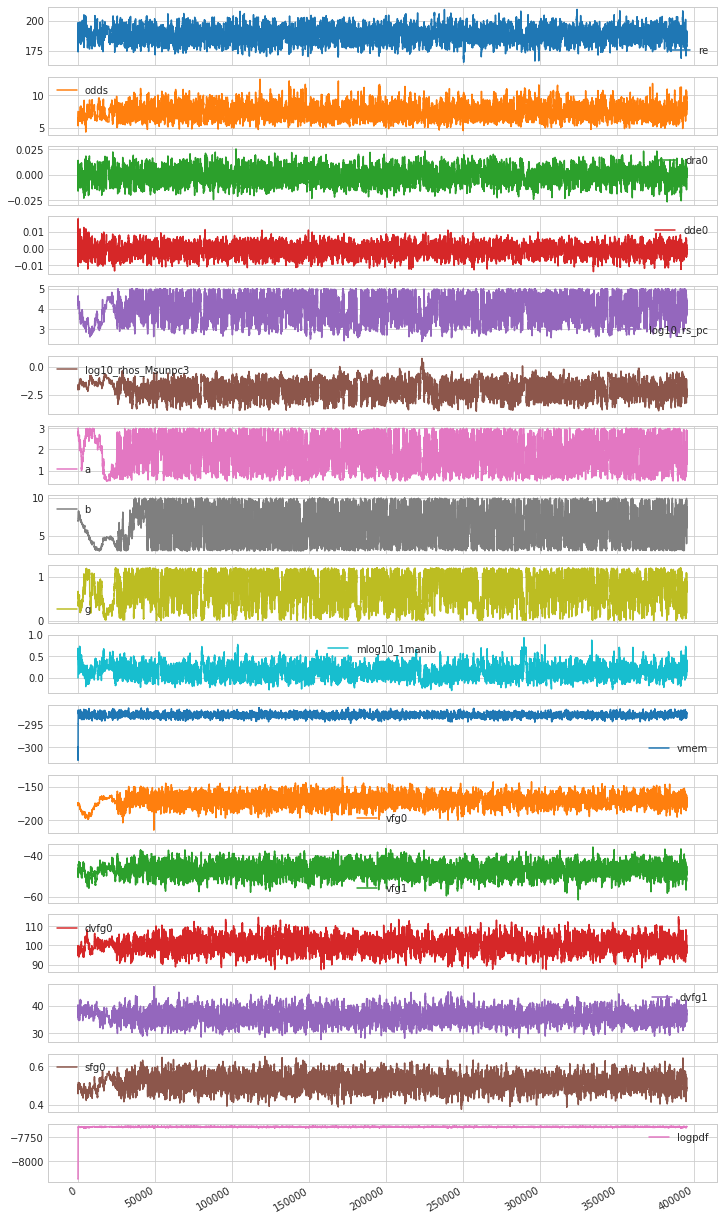

In [164]:
gen.to_DataFrame()[:].plot(subplots=True,figsize=(12,24))

,re,odds,dra0,dde0,log10_rs_pc,log10_rhos_Msunpc3,a,b,g,mlog10_1manib,vmem,vfg0,vfg1,dvfg0,dvfg1,sfg0,logpdf
count,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000,355001.000000
mean,188.455724,7.529662,-0.000785,-0.000899,3.990829,-2.003003,1.802655,6.361209,0.700940,0.143325,-292.841331,-169.838028,-47.077338,100.364367,36.222547,0.515470,-7643.453447
std,5.635773,1.036888,0.006891,0.003311,0.602696,0.781971,0.704745,2.025718,0.312424,0.152192,0.434154,7.875754,2.958318,3.575571,2.362846,0.034989,2.598846
min,165.385705,4.552773,-0.026626,-0.013816,2.389205,-3.964810,0.500044,3.000212,0.000580,-0.289865,-294.684903,-214.835886,-61.481062,87.359007,27.677626,0.377415,-7660.371624
16%,182.829818,6.520810,-0.007695,-0.004244,3.310043,-2.832686,0.986358,3.995142,0.338890,-0.003538,-293.273626,-177.728051,-49.949339,96.835467,33.897445,0.480762,-7645.951910
50%,188.466814,7.443430,-0.000866,-0.000867,4.009248,-1.974989,1.814933,6.297277,0.742610,0.129489,-292.830369,-169.718988,-47.001634,100.216455,36.176416,0.515385,-7643.157144
84%,194.065121,8.530890,0.006083,0.002428,4.677932,-1.188928,2.624533,8.775193,1.038208,0.287748,-292.406381,-162.012622,-44.144086,103.954207,38.584828,0.550522,-7640.899739
max,209.644823,12.480385,0.025303,0.011306,4.999932,0.738442,2.999669,9.998929,1.199986,0.934624,-291.121463,-135.670694,-36.005839,114.900919,47.093665,0.649524,-7637.936204


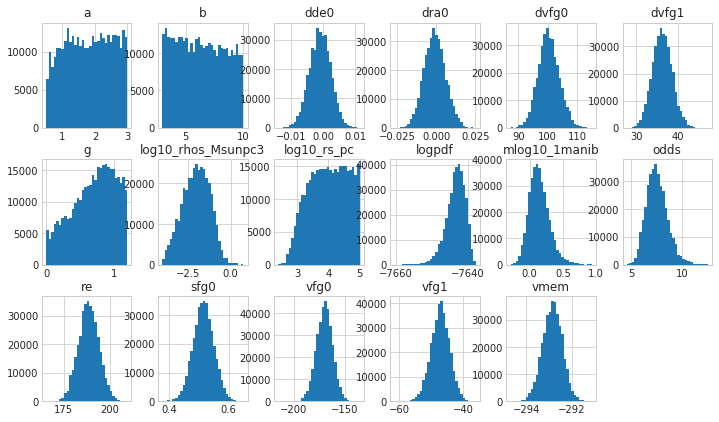

In [165]:
df_plot = gen.to_DataFrame()[40000:]
df_plot.hist(bins=32,layout=(5,6),figsize=(12,12))
df_plot.describe(percentiles=[0.16,0.5,0.84])

In [99]:
val = gen.to_DataFrame()[gen.to_DataFrame().logpdf==0].iloc[0]
val = val.drop("logpdf")
val

re                    134.334112
odds                   19.354276
dra0                    0.013786
dde0                   -0.006296
log10_rs_pc             2.838317
log10_rhos_Msunpc3      0.414890
a                       0.602573
b                       5.276281
g                       0.420136
mlog10_1manib          -0.644137
vmem                 -292.339038
vfg0                 -182.031376
vfg1                  -46.159315
dvfg0                  89.689325
dvfg1                  39.634169
sfg0                    0.479779
Name: 138031, dtype: float64

## test

In [133]:
loglikeli(**val)
loglikeli.dsph.sigmalos2_dequad(loglikeli.Rs(0,0))


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1653: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1654: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)


sigmalos:[nan nan nan ... nan nan nan]
fmem:[nan nan nan ... nan nan nan]
s*fmem+(1-s)*ffg:0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
1535   NaN
1536   NaN
1537   NaN
1538   NaN
1539   NaN
1540   NaN
1541   NaN
1542   NaN
1543   NaN
1544   NaN
1545   NaN
1546   NaN
1547   NaN
1548   NaN
1549   NaN
1550   NaN
1551   NaN
1552   NaN
1553   NaN
1554   NaN
1555   NaN
1556   NaN
1557   NaN
1558   NaN
1559   NaN
1560   NaN
1561   NaN
1562   NaN
1563   NaN
1564   NaN
Length: 1438, dtype: float64


array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
gen.generate_tuned((10000,50000,100000,1000000),proposal_dist="multivariate_normal")

MCgeneration start.
options: {}
5.110% completed... acceptance rate: 7.05%
10.290% completed... acceptance rate: 5.44%
15.640% completed... acceptance rate: 4.80%
20.510% completed... acceptance rate: 4.92%
25.380% completed... acceptance rate: 5.04%
30.680% completed... acceptance rate: 5.15%
35.730% completed... acceptance rate: 4.87%
41.150% completed... acceptance rate: 4.84%
46.290% completed... acceptance rate: 4.69%
52.320% completed... acceptance rate: 4.87%
56.940% completed... acceptance rate: 4.81%
61.470% completed... acceptance rate: 4.91%
66.010% completed... acceptance rate: 4.88%
70.480% completed... acceptance rate: 4.80%
75.010% completed... acceptance rate: 4.87%
79.610% completed... acceptance rate: 4.87%
84.100% completed... acceptance rate: 4.89%
88.530% completed... acceptance rate: 4.91%
93.040% completed... acceptance rate: 4.88%
97.650% completed... acceptance rate: 4.87%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
re                    5.00
odd

39.882% completed... acceptance rate: 7.97%
41.216% completed... acceptance rate: 8.03%
42.830% completed... acceptance rate: 8.13%
43.946% completed... acceptance rate: 8.23%
45.262% completed... acceptance rate: 8.29%
46.380% completed... acceptance rate: 8.40%
47.464% completed... acceptance rate: 8.52%
48.654% completed... acceptance rate: 8.61%
49.950% completed... acceptance rate: 8.59%
51.016% completed... acceptance rate: 8.70%
52.540% completed... acceptance rate: 8.61%
54.166% completed... acceptance rate: 8.46%
55.650% completed... acceptance rate: 8.43%
56.872% completed... acceptance rate: 8.35%
58.088% completed... acceptance rate: 8.36%
59.136% completed... acceptance rate: 8.46%
60.268% completed... acceptance rate: 8.51%
61.594% completed... acceptance rate: 8.54%
63.040% completed... acceptance rate: 8.56%
64.292% completed... acceptance rate: 8.66%
65.094% completed... acceptance rate: 8.71%
66.258% completed... acceptance rate: 8.74%
67.282% completed... acceptance 

/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


0.785% completed... acceptance rate: 4.84%
1.677% completed... acceptance rate: 3.76%
2.697% completed... acceptance rate: 3.86%
3.400% completed... acceptance rate: 3.29%
3.968% completed... acceptance rate: 3.40%
4.734% completed... acceptance rate: 3.61%
5.575% completed... acceptance rate: 3.64%
6.234% completed... acceptance rate: 3.63%
6.966% completed... acceptance rate: 3.82%
7.567% completed... acceptance rate: 3.98%
8.547% completed... acceptance rate: 3.84%
9.618% completed... acceptance rate: 3.84%
10.846% completed... acceptance rate: 3.82%
11.490% completed... acceptance rate: 3.84%
12.274% completed... acceptance rate: 3.90%
12.939% completed... acceptance rate: 3.91%
13.571% completed... acceptance rate: 3.99%
14.361% completed... acceptance rate: 4.01%
15.074% completed... acceptance rate: 4.13%
16.008% completed... acceptance rate: 4.05%
16.869% completed... acceptance rate: 4.20%
17.735% completed... acceptance rate: 4.24%
18.463% completed... acceptance rate: 4.22%


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1653: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1654: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)


73.505% completed... acceptance rate: 4.20%
74.360% completed... acceptance rate: 4.61%
75.154% completed... acceptance rate: 5.02%
76.006% completed... acceptance rate: 5.42%
76.923% completed... acceptance rate: 5.83%
77.872% completed... acceptance rate: 6.19%
78.963% completed... acceptance rate: 6.60%
79.928% completed... acceptance rate: 7.02%
80.779% completed... acceptance rate: 7.40%
81.637% completed... acceptance rate: 7.75%
82.365% completed... acceptance rate: 8.12%
83.215% completed... acceptance rate: 8.45%
84.031% completed... acceptance rate: 8.80%
84.857% completed... acceptance rate: 9.14%
85.584% completed... acceptance rate: 9.46%
86.609% completed... acceptance rate: 9.77%
87.648% completed... acceptance rate: 10.07%
88.786% completed... acceptance rate: 10.36%
89.611% completed... acceptance rate: 10.67%
90.399% completed... acceptance rate: 10.97%
91.309% completed... acceptance rate: 11.26%
92.068% completed... acceptance rate: 11.53%
93.033% completed... accep

/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0.171% completed... acceptance rate: 17.82%
0.341% completed... acceptance rate: 18.24%
0.525% completed... acceptance rate: 19.24%
0.723% completed... acceptance rate: 19.05%
0.891% completed... acceptance rate: 18.98%
1.003% completed... acceptance rate: 19.32%
1.144% completed... acceptance rate: 19.50%
1.270% completed... acceptance rate: 19.71%
1.387% completed... acceptance rate: 19.70%
1.510% completed... acceptance rate: 19.68%
1.662% completed... acceptance rate: 19.45%
1.790% completed... acceptance rate: 19.60%
1.922% completed... acceptance rate: 19.66%
2.055% completed... acceptance rate: 19.63%
2.208% completed... acceptance rate: 19.66%
2.335% completed... acceptance rate: 19.77%
2.474% completed... acceptance rate: 19.82%
2.622% completed... acceptance rate: 19.84%
2.766% completed... acceptance rate: 19.75%
2.911% completed... acceptance rate: 19.81%
3.044% completed... acceptance rate: 19.82%
3.184% completed... acceptance rate: 19.89%
3.329% completed... acceptance r

In [ ]:
gen.to_DataFrame()[:].plot(subplots=True)

In [ ]:
gen.options["push_time"] = 30
gen.generate(200000)

## results

In [166]:
result_df = gen.to_DataFrame()
resultlog_df = gen.to_DataFrame(output_log=True)
resultlog_df

,0,re,odds,dra0,dde0,log10_rs_pc,log10_rhos_Msunpc3,a,b,g,mlog10_1manib,vmem,vfg0,vfg1,dvfg0,dvfg1,sfg0
re,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odds,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dra0,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dde0,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log10_rs_pc,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log10_rhos_Msunpc3,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mlog10_1manib,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


if you already done the calculation, load the result below.

In [ ]:
#result_df = pd.read_csv("MCMCresult/MCMC_refR-re-w-center_v001.csv")
#resultlog_df = pd.read_csv("MCMCresult/MCMClog_refR-re-w-center_v001.csv")

In [ ]:
ploted_stepset = 1
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
#result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

In [ ]:
mypairplot(result_df[-last_MCMC_steps::50])
#mypairplot(result_df[-lastMCMCsteps])

In [ ]:
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

In [ ]:
plots_likelis = pd.DataFrame()
#plots_likelis["R"] = Rs # ideally loglikeli.R but approzimately here we use Rs
plots_likelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"])
plots_likelis["prob"] = np.exp(np.log(2*np.pi*plots_likelis.R)+loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis[::].plot(x="R",y="prob",ax=ax,figsize=(12,6))
display(plots_likelis[::].hist("R",bins=32,density=True,alpha=0.3,ax=ax))

In [ ]:
plots_loglikelis = pd.DataFrame()
plots_loglikelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"]) # ideally loglikeli.R but approzimately here we use Rs
plots_loglikelis["loglikeli"] = loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"]))
plots_loglikelis = plots_loglikelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_loglikelis[::].plot(x="R",y="loglikeli",ax=ax,figsize=(12,6))

## export

In [167]:
SPECIFY_NAME = "spectroscopy_sig_refR-re-w-center_2gaussian_plummer_Rsig-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="va002"
result_df.to_csv(FNAME_BASE.format("",SPECIFY_NAME,VERSION),index=None)
resultlog_df.to_csv(FNAME_BASE.format("log",SPECIFY_NAME,VERSION),index=None)

# WBIC calculation

In [ ]:
#update likelihood
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs,beta=1):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            return np.sum(self.loglikelis(re,odds,dra0,dde0))
    def loglikelis(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return self.beta * ret


In [ ]:
loglikeli_wbic = KI17_loglikelihood_mod(dRAs=df_deg.x,dDEs=df_deg.y,beta=1/np.log(len(df_deg)))

In [ ]:
gen_wbic = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"n":0.8,"odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"n":0.1,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli_wbic
)

In [ ]:
gen_wbic.generate(5000)

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate_tuned((5000,5000,5000))

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate(100000)

In [ ]:
df_wbic = gen_wbic.to_DataFrame()[-100000:]
df_wbiclog = gen_wbic.to_DataFrame(output_log=True)
mypairplot(df_wbic[::20])

In [ ]:
wbic = -df_wbic.logpdf.mean()/loglikeli_wbic.beta
bic = -gen.to_DataFrame()[-100000:].logpdf.max() + len(gen.args_logpdf_init)/loglikeli_wbic.beta /2
print(" BIC:{}\nWBIC:{}".format(bic,wbic))

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME+"_wbic"
version = VERSION
df_wbic.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)